# BSRC: Summer 2019 Research Project 

## Project Initial Stage

_"The initial stage of the project will be to write a script to select, from a catalog of choice, a number of objects (for example, pulsars) in a given area of sky."_

This notebook is used to demonstrate the ability This code must be able to:

- Open a catalogue/database of objects with RA and DEC coordinates defining their position
- Compute the great-circle angular distance between these object to account for the fact that these objects are pasted to a sphere
- Run quickly and efficiently considering the number of targets in the database

Start by importing useful packages. Astropy will be used for unit and coordinate transformations and astroquery will handle the import of a dataset.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery import open_exoplanet_catalogue as oec
from astroquery.open_exoplanet_catalogue import findvalue

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [9]:
cata = oec.get_catalogue()

Create a SkyCoord object which defines the coordinates of all the exoplanets within the Open Exoplanet Catalogue. This step is used to create a sample database of targets that the functions below will search through.

In [10]:
coord_list = []

for systems in cata.findall(".//system[declination][rightascension]"):
    coords = '{} {}'.format(findvalue( systems, 'rightascension'), findvalue(systems, 'declination'))
    coord_list.append(coords)
    
planet_coords = SkyCoord(coord_list, unit=(u.hourangle, u.deg))

Now that the "database" is generated, a function can be defined to select targets within the beam of some telescope pointing.

In [19]:
def select_targets(c_ra, c_dec, beam_rad, coords):
    """
    Returns a numpy array of objects that fall within the beam of a designated right ascension and declination
    
    Params
    ------
    
    c_ra (float) - pointing right ascension listed in degrees
    c_dec (float) - pointing declination listed in degrees
    beam_rad (float) - beam radius in degrees
    coords (numpy array: SkyCoord) - list of coordinates for objects 
    
    Returns
    -------
    
    list of objects within the beam
    
    """
    pointing = SkyCoord(c_ra, c_dec, unit=(u.deg))
    dist = pointing.separation(coords).degree
    idx = np.where(dist <= beam_rad)[0]
    return idx 

Now I'll define the center right ascension and declination of the direction the telescope is pointing as well as the beam radius. These quantities will be used to select targets from the list.

In [35]:
c_ra = 295.0 # deg
c_dec = -20.0 # deg
beam_rad = 10.0 # deg

idx = select_targets(c_ra, c_dec, beam_rad, planet_coords)
targets = planet_coords[idx]

In [38]:
np.sort(targets.separation(SkyCoord(c_ra, c_dec, unit=u.deg)).deg)[::-1]

array([9.61529675, 9.53068235, 7.03695764, 7.03392613, 5.98738548,
       5.97834214, 5.74855363, 5.74078979, 5.69221267, 5.49660725,
       4.57978914, 4.45942659, 3.93910453, 3.40504803, 2.29717586,
       0.70278668])

Finally, let's plot the targets against the beam to make sure things look reasonable.

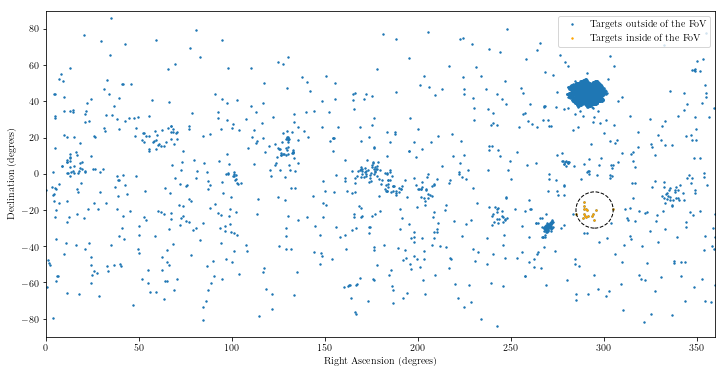

In [45]:
plt.figure(figsize=(12,6))
circle = plt.Circle((c_ra, c_dec), beam_rad, fill=False, linestyle='--')
ax = plt.gca()
ax.cla()
ax.scatter(planet_coords.ra.deg, planet_coords.dec.deg, s=2, label = 'Targets outside of the FoV')
#ax.scatter(c_ra, c_dec, s=10, color = 'black')
ax.scatter(planet_coords[idx].ra.degree, planet_coords[idx].dec.degree, s=2, color = 'orange', label = 'Targets inside of the FoV')
ax.set_xlim([0,360])
ax.set_ylim([-90, 90])
ax.set_xlabel('Right Ascension (degrees)')
ax.set_ylabel('Declination (degrees)')
ax.add_artist(circle)
ax.legend()
#plt.show()
plt.savefig('target_selection.png', dpi=100)